Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime, timezone
import csv
from sklearn import svm
users = pd.read_csv('ml-users.csv')

In [3]:
# parses through each user's csv and figures out how many unique panos and missions seen
user_panos = {}
user_missions = {}
for current_user in users['user_id']:
    df_current = pd.read_csv('{0}.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
    user_missions[current_user] = df_current['mission_id'].nunique()
df_current = None

In [245]:
user_times = pd.read_csv('user_times.csv')

In [244]:
# parses through each user's csv and figures out the total time spent labeling based off of
# start and end time of a mission
temp = {}
current_times = []
current_mission = ''
time_total = 0
#for current_user in users['user_id']:
current_user = 'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c'
df_current = pd.read_csv('{0}.csv'.format(current_user))
for index, time in enumerate(df_current['timestamp']):
#     if index < 10000:
#         display(time)
    if time.count(':') == 1:
            time = '00:'+ time
    if df_current['mission_id'].iloc[index] != current_mission:
        if len(current_times) > 0:
            time_total = time_total + (max(current_times) - min(current_times))
        display(time)
        current_times = [(datetime.now(timezone.utc) - parser.parse(time)).total_seconds()]
        current_mission = df_current['mission_id'].iloc[index]
    else:
        current_times.append((datetime.now(timezone.utc) - parser.parse(time)).total_seconds())
    temp[current_user] = time_total

'00:42:33.5'

TypeError: can't subtract offset-naive and offset-aware datetimes

In [138]:
# Creates a csv of the total amount of time that the 
time_header = ['user_id', 'total_time_spent']
with open('user_times.csv', 'w', newline = '') as new_user:
    writer = csv.writer(new_user)
    writer.writerow(time_header)
with open('user_times.csv', 'a', newline = '') as edit_user:
    editor = csv.writer(edit_user)
    for entry in user_times.keys():
        editor.writerow([entry, user_times[entry]])

In [204]:
# df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
# #df_interactions = pd.read_csv('ml-interactions15000.csv')

# # Do a little cleanup...
# # In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# # not happen. So, let's find that row (and others) that have this problem and remove them

# # pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# # row and the value corresponds to True/False indicating whether there is a NaN value
# isna_result = pd.isna(df_interactions['action'])

# print("Printing all rows where 'action' == NaN...")
# display(df_interactions[isna_result])
# df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# # As a test, we can again look for NaN 'action' cells
# isna_result = pd.isna(df_interactions['action'])
# print("Printing all rows where 'action' == NaN... there should be no rows")
# display(df_interactions[isna_result])

# small represents the first 50000 actions logged to be able to test a smaller subset
# small= df_interactions[:50000]

In [68]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [140]:
# Parses through the csv and creates new csv for every user_id & event
with open('ml-interactions.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
    users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
            users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [3]:
# # This fucntion iterates over the desired dataset and returns all of the logged events
# # that contains the desired action
# def find_action(args, use_subset = False):        
#     for index, word in enumerate(args):  
#         if use_subset:
#             if index == 0:
#                 df_information = small[small['action'].str.contains(word)]
#             else:
#                 frames = [df_information, small[small['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#         else:
#             if index == 0:
#                 df_information = df_interactions[df_interactions['action'].str.contains(word)]
#             else:
#                 frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#     return df_information

In [299]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission. Time graph determines if it is measured by minute
# Unsure why but when measuring time, the user fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c has
# a way higher value than all other users, unsure why
def counting_graph (info_type, graph_type, multi_plot, action, time, period):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    time_period = 1
    if period == 'Minutes':
        time_period = 60
    elif period == 'Hours':
        time_period = 3600
    for index, current_id in enumerate(df_actions_grouped.groups):
        users_index = (users['user_id'] == current_id).idxmax()
        if time and index < 15:
            user_information[current_id] = len(df_actions_grouped.get_group(current_id)) / (user_times['total_time_spent'][users_index] / time_period), users[' accuracy'][users_index]
        elif not time:
            user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users[' accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users[' accuracy'][index]
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot, time, period)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [184]:
# def time_graph (info_type, multi_plot, action):
#     user_information = {}
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     for index, current_id in enumerate(df_actions_grouped.groups):
#         users_index = (users['user_id'] == current_id).idxmax()
#         user_information[current_id] = len(df_actions_grouped.get_group(current_id)) / (user_times[current_id] / 60), users[' accuracy'][users_index]
#     for index, current_user in enumerate(users['user_id']):
#         if current_user not in user_information:
#             user_information[current_user] = 0, users[' accuracy'][index]
#     scatter_plot(info_type, user_information, multi_plot, True)

In [5]:
# In progress
def range_graph(info_type, graph_type, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        current_min = df_actions_grouped.get_group(current_id).min()
        current_max = df_actions_grouped.get_group(current_id).max()
        current_accuracy = users[' accuracy'][index]
        user_information[current_id] = current_max - current_min, current_accuracy
    if graph_type == 'scatter_plot' :
        scatter_plot(info_type, user_information, False)

In [27]:
# # Determines the average time it takes for a certain action to occur per second and per
# # either panos or mission
# # The type of information is found using the action logged
# # Currently takes too long and doesn't run all the way, even when only processing only 
# # Per panos or per mission
# def time_graph(info_type, action):
#     df_info = pd.read_csv('{0}.csv'.format(action))
#     df_per_pano = df_info.groupby(['user_id', 'gsv_panorama_id'])
#     df_per_mission = df_info.groupby(['user_id','mission_id'])
#     user_info = {}
#     current_group_times = []
#     for name,group_pano in df_per_pano:
#         for current_datetime in group_pano['timestamp']:
#             current_group_times.append(parser.parse(current_datetime))
#         if name[0] in user_info:
#             user_info[name[0]] = user_info[name[0]][0] + (max(current_group_times) - min(current_group_times)).total_seconds(), 0
#         else:
#             user_info[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds(), 0
#     for name,group_mission in df_per_mission:
#         for current_datetime in group_mission['timestamp']:
#             current_group_times.append(parser.parse(current_datetime))
#         user_info[name[0]][1] = user_info[name[0]][1] + (max(current_group_times) - min(current_group_times)).total_seconds()
#     time_scatter_plot(info_type, user_info)

In [29]:
# def time_graph(info_type, action):
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     user_info = {}
#     current_pano_times = []
#     current_mission_times = []
#     current_pano = ''
#     current_mission = ''
#     pano_time_total = 0
#     mission_time_total = 0
#     count = 0
#     for name, current_group in df_actions_grouped:
#         for index, time in enumerate(current_group['timestamp']):
# #             if count < 1:
# #                 count += 1
# #                 display(current_group['gsv_panorama_id'])
# #                 display(current_group['gsv_panorama_id'].keys())
#             if current_group['gsv_panorama_id'].index[index] != current_pano:
#                 if len(current_pano_times) > 0:
#                     pano_time_total = pano_time_total + (max(current_pano_times) - min(current_pano_times))
#                 current_pano_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())
#                 current_pano = current_group['gsv_panorama_id'].index[index]
#             else:
#                 read_time = (parser.parse(time) - datetime.now(timezone.utc)).total_seconds()
#                 current_pano_times.append(read_time)
#             if current_group['mission_id'].index[index] != current_mission:
#                 if len(current_mission_times) > 0:
#                     mission_time_total = mission_time_total + (max(current_mission_times) - min(current_mission_times))
#                 current_mission_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())
#                 current_mission = current_group['mission_id'].index[index]
#             else:
#                 current_mission_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())  
#         user_info[name] = pano_time_total, mission_time_total
# #     time_scatter_plot(info_type, user_info)

In [6]:
# def time_graph(info_type, action):
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     user_info = {}
#     for name, current_group in df_actions_grouped:
#         current_times = []
#         current_mission = ''
#         time_total = 0
#         for index, time in enumerate(current_group['timestamp']):
#             if current_group['mission_id'].iloc[index] != current_mission:
#                 if len(current_times) > 0:
#                     time_total = time_total + (max(current_times) - min(current_times))
#                 current_times = [(datetime.now(timezone.utc) - parser.parse(time)).total_seconds()]
#                 current_mission = current_group['mission_id'].iloc[index]
#             else:
#                 current_times.append((datetime.now(timezone.utc) - parser.parse(time)).total_seconds())  
#         user_info[name] = time_total
#     time_scatter_plot(info_type, user_info)

In [147]:
# # Creates a scatter plot relating accuracy and the occurance of an action per second per
# # panos or mission
# def time_scatter_plot(info_type, user_info, multi_plot):
#     f, axs = plt.subplots(1,2,figsize=(12,4))
#     plt.subplot(122)
#     plt.ylabel('User Accuracy')
#     plt.xlabel(info_type + ' per second per Pano')
#     for index, entry in enumerate(user_info.keys()):
#         current_info = user_info.get(entry)
#         info = float(current_info[0])
#         accuracy = users[' accuracy'][index]
#         if accuracy > 65:
#             plt.plot(info, accuracy, '.', color = 'blue')
#         else:
#             plt.plot(info, accuracy, '.', color = 'red')
#     plt.subplot(121)
#     plt.ylabel('User Accuracy')
#     plt.xlabel(info_type + ' per second per Mission Started')
#     for index, entry in enumerate(user_info.keys()):
#         current_info = user_info.get(entry)
#         info = float(current_info[1])
#         accuracy = users[' accuracy'][index]
#         if accuracy > 65:
#             plt.plot(info, accuracy, '.', color = 'blue')
#         else:
#             plt.plot(info, accuracy, '.', color = 'red')

In [301]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, multi_plot, per_time, period):
    if multi_plot:
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        if per_time:
            plt.xlabel(info_type + ' per ' + period + ' per Pano')
        else:
            plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            if accuracy > 65:
                plt.plot(info, accuracy, '.', color = 'blue')
            else:
                plt.plot(info, accuracy, '.', color = 'red')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        if per_time:
            plt.xlabel(info_type + ' per ' + period + ' per Mission Started')
        else:
            plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            if accuracy > 65:
                plt.plot(info, accuracy, '.', color = 'blue')
            else:
                plt.plot(info, accuracy, '.', color = 'red')
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    if per_time:
        plt.xlabel(info_type + ' per ' + period)
    else:
        plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'blue')
        else:
            plt.plot(info, accuracy, '.', color = 'red')

In [9]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

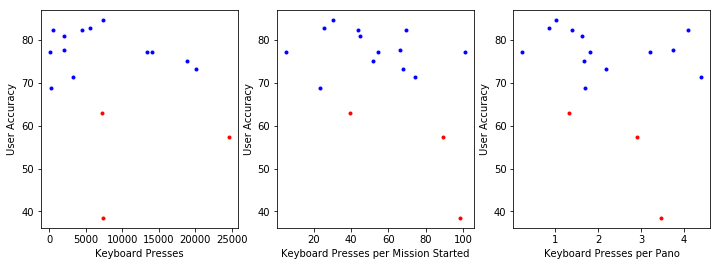

In [302]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown', False, None)

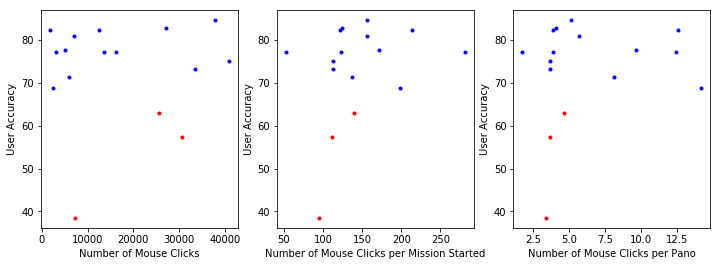

In [158]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown', False, None)

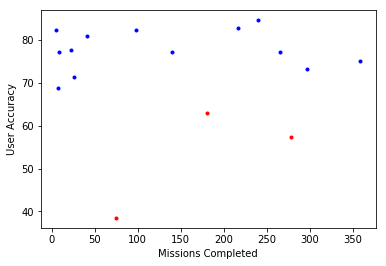

In [256]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete', False, None)

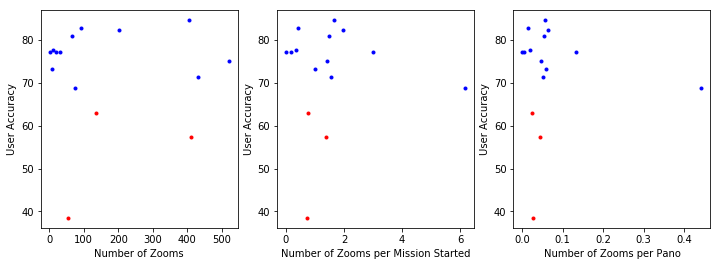

In [11]:
# Counts the number of zooms
counting_graph('Zooms', 'scatter_plot', True, 'Click_ZoomIn', False, None)

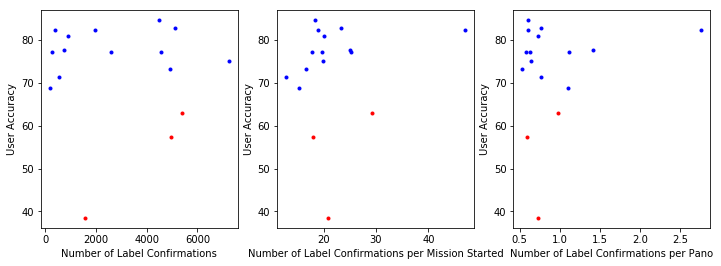

In [37]:
# Counts the number of Labels confirmations based off of time the context menu was opened
counting_graph('Label Confirmations', 'scatter_plot', True, 'ContextMenu_Open', False, None)

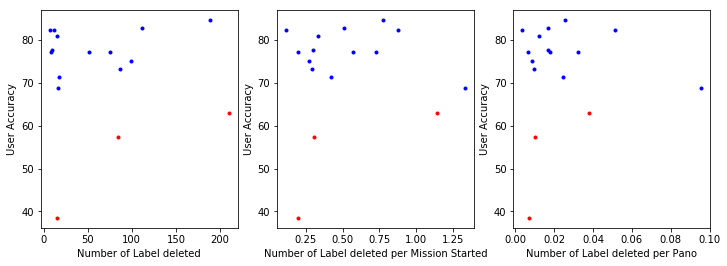

In [13]:
# Counts the number of Labels Deleted
counting_graph('Label deleted', 'scatter_plot', True, 'RemoveLabel', False, None)

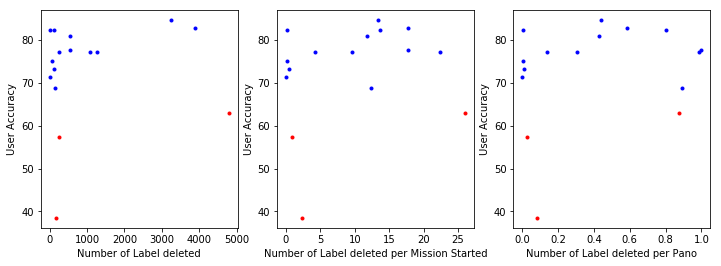

In [14]:
# Counts the number of Tags Placed
counting_graph('Label deleted', 'scatter_plot', True, 'ContextMenu_TagAdded', False, None)

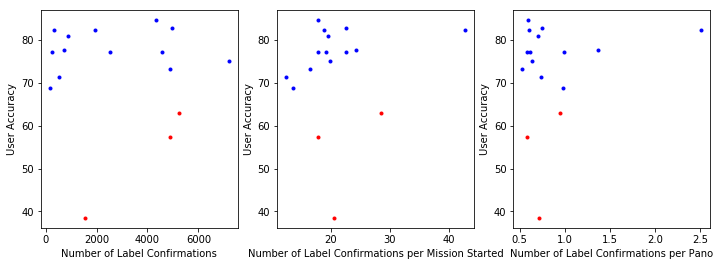

In [35]:
# Counts the number of Label Confirmation based off of closing the context window
# I am currently unsure whether this one or the one above would be a more accurate measure
# of labels done and what the other would represent
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling', False, None)

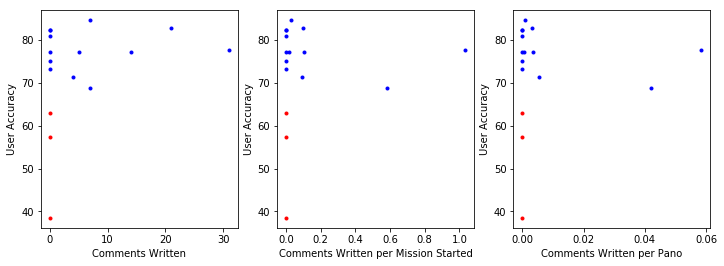

In [295]:
# Counts the number of Comments Written
# Unsure if measuring the blur of the text box is an accurate representation of comments written
counting_graph('Comments Written', 'scatter_plot', True, 'ContextMenu_TextBoxChange', False, None)

In [128]:
# # Counts the number of comments written

# user_information = {}
# df_comments = pd.read_csv('{0}.csv'.format('ContextMenu_TextBoxBlur'))
# df_window_closes = pd.read_csv('{0}.csv'.format('ContextMenu_Close'))
# df_comments_grouped = df_comments.groupby(['user_id'])
# df_window_closes_grouped = df_window_closes.groupby(['user_id'])
# for index, current_id in enumerate(df_comments_grouped.groups):
#     user_information[current_id] = len(df_comments_grouped.get_group(current_id)), users[' accuracy'][index]
# scatter_plot('Comments Written', user_information, True)

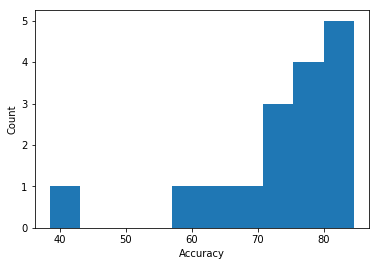

In [17]:
# Counts the number of users with different accuracies
histogram('Accuracy', users[' accuracy'])

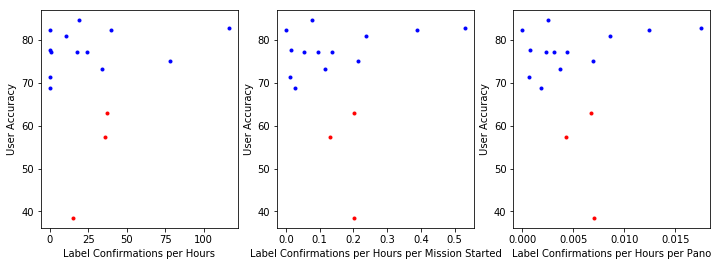

In [303]:
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling', True, 'Hours')

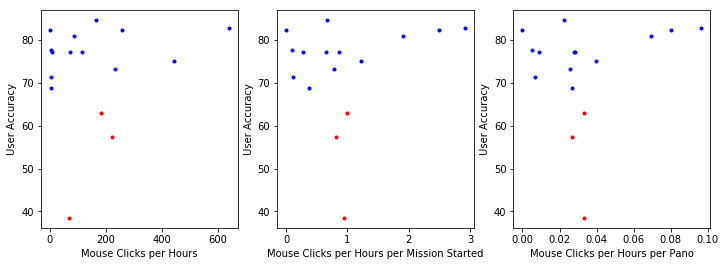

In [304]:
# Counts the number of mouse clicks per minute
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown', True, 'Hours')

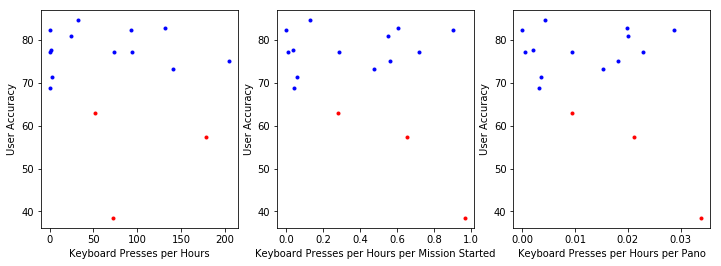

In [311]:
# Counts the number of keyboard presses per minute
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown', True, 'Hours')

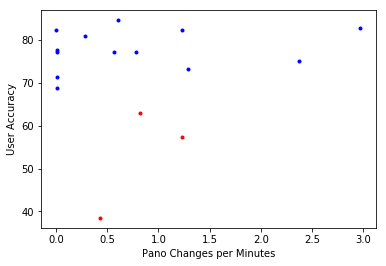

In [307]:
# Counts the number of Pano changes per minute
counting_graph('Pano Changes', 'scatter_plot', False, 'PanoId_Changed', True, 'Minutes')

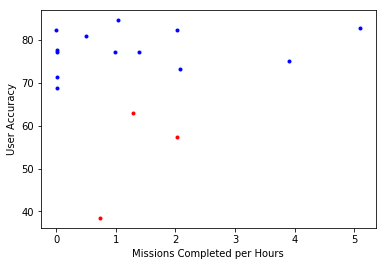

In [308]:
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete', True, 'Hours')

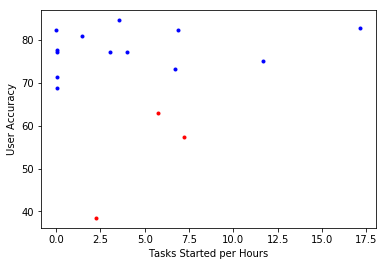

In [309]:
counting_graph('Tasks Started', 'scatter_plot', False, 'TaskStart', True, 'Hours')

In [99]:
test_data = []
training_data = []
header = ['Quality']
test_id = []
training_id = []
create_groups(13)
# add_feature('LowLevelEvent_mousedown', 'ContextMenu_TextBoxFocus', 'LowLevelEvent_keydown', )
# header = ['Mouse Clicks per Panos', 'Mouse Clicks per Mission', 'Comments per Panos', 
#           'Comments per Mission', 'Key Presses per Panos', 'Key Presses per Mission',
#           'Quality']

In [286]:
display(test_id)
display(training_id)

['ec15a589-dd14-4513-a43e-8c06e55f4c71',
 'f13d2630-35fd-4a78-883d-d108be083425',
 'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c']

['0e1ae564-6d72-4670-98e4-71369cc5ab26',
 '2d9009b3-55d5-4aa8-a17a-a7c80afc4d51',
 '49723673-044d-4b47-855b-3bdebfe37073',
 '7b1596af-14d4-4f2b-9e4e-71b1884db836',
 '86d26e9d-010f-4802-88ba-680ae0a8e20d',
 '87833d72-b357-4e2c-81cd-23f58ff04c59',
 '9b595ba6-529b-4d37-93d7-dd189184e15a',
 'ac272eb8-3bb3-4260-9960-8e6c463f3867',
 'af812204-1521-4c42-bf88-4baaaffe3f06',
 'bca24c1a-a6b1-4625-ab8e-9ff8693022d7',
 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b',
 'dada416e-535f-4bb3-a213-172a8a94b581',
 'e4ff325c-309b-4ea6-8555-8f973e662362']

In [287]:
display(training_data)
display(test_data)
display(header)

[['Good', 1.6758295525309137, 51.752747252747255, 0, 0],
 ['Good',
  1.0070757926248468,
  30.45679012345679,
  0.0009525105456524698,
  0.02880658436213992],
 ['Good',
  0.8472222222222222,
  25.625570776255707,
  0.003170289855072464,
  0.0958904109589041],
 ['Good', 1.393977025768395, 43.592233009708735, 0, 0],
 ['Bad', 3.455737704918033, 98.37333333333333, 0, 0],
 ['Good', 3.7528301886792454, 66.3, 0.05849056603773585, 1.0333333333333334],
 ['Good', 0.23293172690763053, 5.2727272727272725, 0, 0],
 ['Good', 1.6335754640839386, 44.977777777777774, 0, 0],
 ['Good',
  1.8051848049281314,
  54.731517509727624,
  0.0006416837782340862,
  0.019455252918287938],
 ['Bad', 1.319505094614265, 39.41304347826087, 0, 0],
 ['Good',
  3.217695274831244,
  101.11363636363636,
  0.0033751205400192863,
  0.10606060606060606],
 ['Good',
  1.6946107784431137,
  23.583333333333332,
  0.041916167664670656,
  0.5833333333333334],
 ['Good',
  4.409090909090909,
  74.44186046511628,
  0.005509641873278237,


[['Bad', 2.9150753172814614, 89.3709090909091, 0, 0],
 ['Good', 2.1872957071257355, 67.5925925925926, 0, 0],
 ['Good', 4.095588235294118, 69.625, 0, 0]]

[]

In [114]:
add_feature('ContextMenu_TextBoxChange', 'count')
header.append('Comments Written per Panos')
header.append('Comments Written per Mission')

In [96]:
def create_groups(number_of_training):
    for index, entry in enumerate(users['user_id']):
        if users[' accuracy'][index] <= 65:
            quality = ['Bad']
        else:
            quality = ['Good']
        if index < number_of_training:
            training_data.append(quality)
            training_id.append(entry)
        else:
            test_data.append(quality)
            test_id.append(entry)

In [13]:
def add_feature(feature, info_type):
    for index, entry in enumerate(users['user_id']):
        df_user = pd.read_csv('{0}.csv'.format(entry))
        action_count = df_user['action'].value_counts()
        if feature in action_count:
            #if info_type == 'count':
            panos =  action_count[feature] / float(user_panos[entry])
            missions = action_count[feature] / float(user_missions[entry])
            if info_type == 'time':
                panos =  panos / user_times[entry]
                missions = missions / user_times[entry]
        else:
            panos = 0
            missions = 0
        if entry in training_id:
            current_index = training_id.index(entry)
            training_data[current_index].append(panos)
            training_data[current_index].append(missions)
        else:
            current_index = test_id.index(entry)
            test_data[current_index].append(panos)
            test_data[current_index].append(missions)

In [289]:
header = ['Quality', 'Key Presses per Panos', 'Key Presses per Mission', 'Comments Written per Panos', 'Comments Written per Mission']

In [290]:
df_test = pd.DataFrame(test_data, columns = header, index = test_id)
df_training = pd.DataFrame(training_data, columns = header, index = training_id)

In [292]:
print('test')
display(df_test)
print('training')
display(df_training)

test


,Quality,Key Presses per Panos,Key Presses per Mission,Comments Written per Panos,Comments Written per Mission
ec15a589-dd14-4513-a43e-8c06e55f4c71,Bad,2.915075,89.370909,0,0
f13d2630-35fd-4a78-883d-d108be083425,Good,2.187296,67.592593,0,0
fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c,Good,4.095588,69.625000,0,0


training


,Quality,Key Presses per Panos,Key Presses per Mission,Comments Written per Panos,Comments Written per Mission
0e1ae564-6d72-4670-98e4-71369cc5ab26,Good,1.675830,51.752747,0.000000,0.000000
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,Good,1.007076,30.456790,0.000953,0.028807
49723673-044d-4b47-855b-3bdebfe37073,Good,0.847222,25.625571,0.003170,0.095890
7b1596af-14d4-4f2b-9e4e-71b1884db836,Good,1.393977,43.592233,0.000000,0.000000
86d26e9d-010f-4802-88ba-680ae0a8e20d,Bad,3.455738,98.373333,0.000000,0.000000
87833d72-b357-4e2c-81cd-23f58ff04c59,Good,3.752830,66.300000,0.058491,1.033333
9b595ba6-529b-4d37-93d7-dd189184e15a,Good,0.232932,5.272727,0.000000,0.000000
ac272eb8-3bb3-4260-9960-8e6c463f3867,Good,1.633575,44.977778,0.000000,0.000000
af812204-1521-4c42-bf88-4baaaffe3f06,Good,1.805185,54.731518,0.000642,0.019455
bca24c1a-a6b1-4625-ab8e-9ff8693022d7,Bad,1.319505,39.413043,0.000000,0.000000


In [293]:
clf = svm.SVC(gamma = 'auto')
features = []
quality = []
for index, entry in enumerate(df_training['Quality']):
    current_features = df_training['Comments Written per Panos'][index], df_training['Comments Written per Mission'][index]
    features.append(current_features)
    quality.append(entry)
features = np.array(features)
quality = np.array(quality)
clf.fit(features, quality.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [294]:
current_test = []
for index, entry in enumerate(df_test['Quality']):
    current_features = df_training['Comments Written per Panos'][index], df_training['Comments Written per Mission'][index]
    current_test.append(current_features)
all_test = np.array(current_test)
clf.predict(current_test)

array(['Good', 'Good', 'Good'], dtype='<U4')

In [313]:
df_finished_labeling = pd.read_csv('LabelingCanvas_FinishLabeling.csv')
df_all_labels = pd.read_csv('ml-label-correctness.csv')

In [317]:
df_finished_labeling.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)

In [322]:
df_all_labels.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)

In [329]:
df_all_labels.drop(columns=('user_id'), inplace=True)

In [331]:
df_joined = df_finished_labeling.join(df_all_labels)

In [334]:
df_joined = df_joined[~pd.isna(df_joined['correct'])]

In [340]:
df_joined = df_joined[df_joined['lat'] > 46]

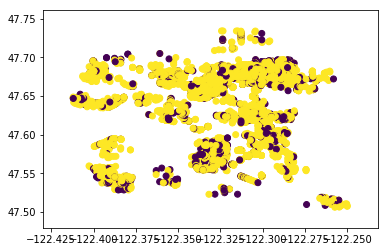

In [347]:
plt.figure()
plt.scatter(df_joined['lng'], df_joined['lat'], c = (df_joined['correct'] == 't') )